# Analysis of stellar spectra


## Background Information on the dataset


You will be working with spectra of stars that have been aquired by the space telescope Gaia (https://www.esa.int/Science_Exploration/Space_Science/Gaia). 

For part of these stars, we have additional information from another observation mission GALAH (https://www.galah-survey.org/) that observed some of these stars as well. This will provide us with some labels for part of the dataset, but we don't (and can't, at the moment) know the "truth" for the stars that have not been observed by GALAH.


spectra are 1D data were each feature corresponds to a wavelength. Here the spectra span a wavelength range of 846–870 nm, with a step of 0.01 nm. 

### Data matrix:

spec_rvs_wise_galah.npy (spectra from Gaia for stars observed by both Gaia and GALAH)  = 21556 spectra of size 2401 each. We refer to it later as spectra_withgalah.
\
spec_NOgalah_rvswise.npy ((spectra from Gaia for stars observed only by Gaia) = 22295 spectra of size 2401 each. we refer to it later as spectraNOgal 

### Additional information dataframe:
gaiaGalah_info_rvswisegalah = information for the stars observed by both GALAH and Gaia (we refer to it later as gaiagal_info)
\
gaia_info_rvswiseNOgalah = information (partial) for the stars only observed by Gaia

### Indexing files:
(This shouldn't be necessary, as the spectra matrix and the dataframe should have the right order, but just in case)

ids_rvs_wise_galah = corresponding IDs of the spectra in spec_rvs_wise_galah (corresponds to "dr3_source_id" in gaiaGalah_info_rvswisegalah
\
ids_NOgalah_rvswise = corresponding IDs of the spectra in spec_rvs_wise_galah (corresponds to "source_id" in gaiaGalah_info_rvswisegalah




Example of a spectrum from the dataset: 

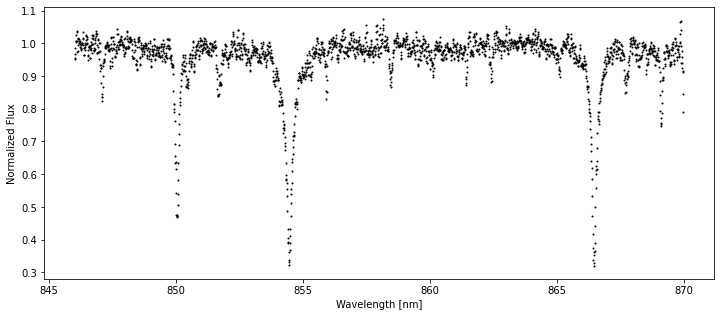


Spectras contain information about the composition of a star through absorbtion and emission lines:


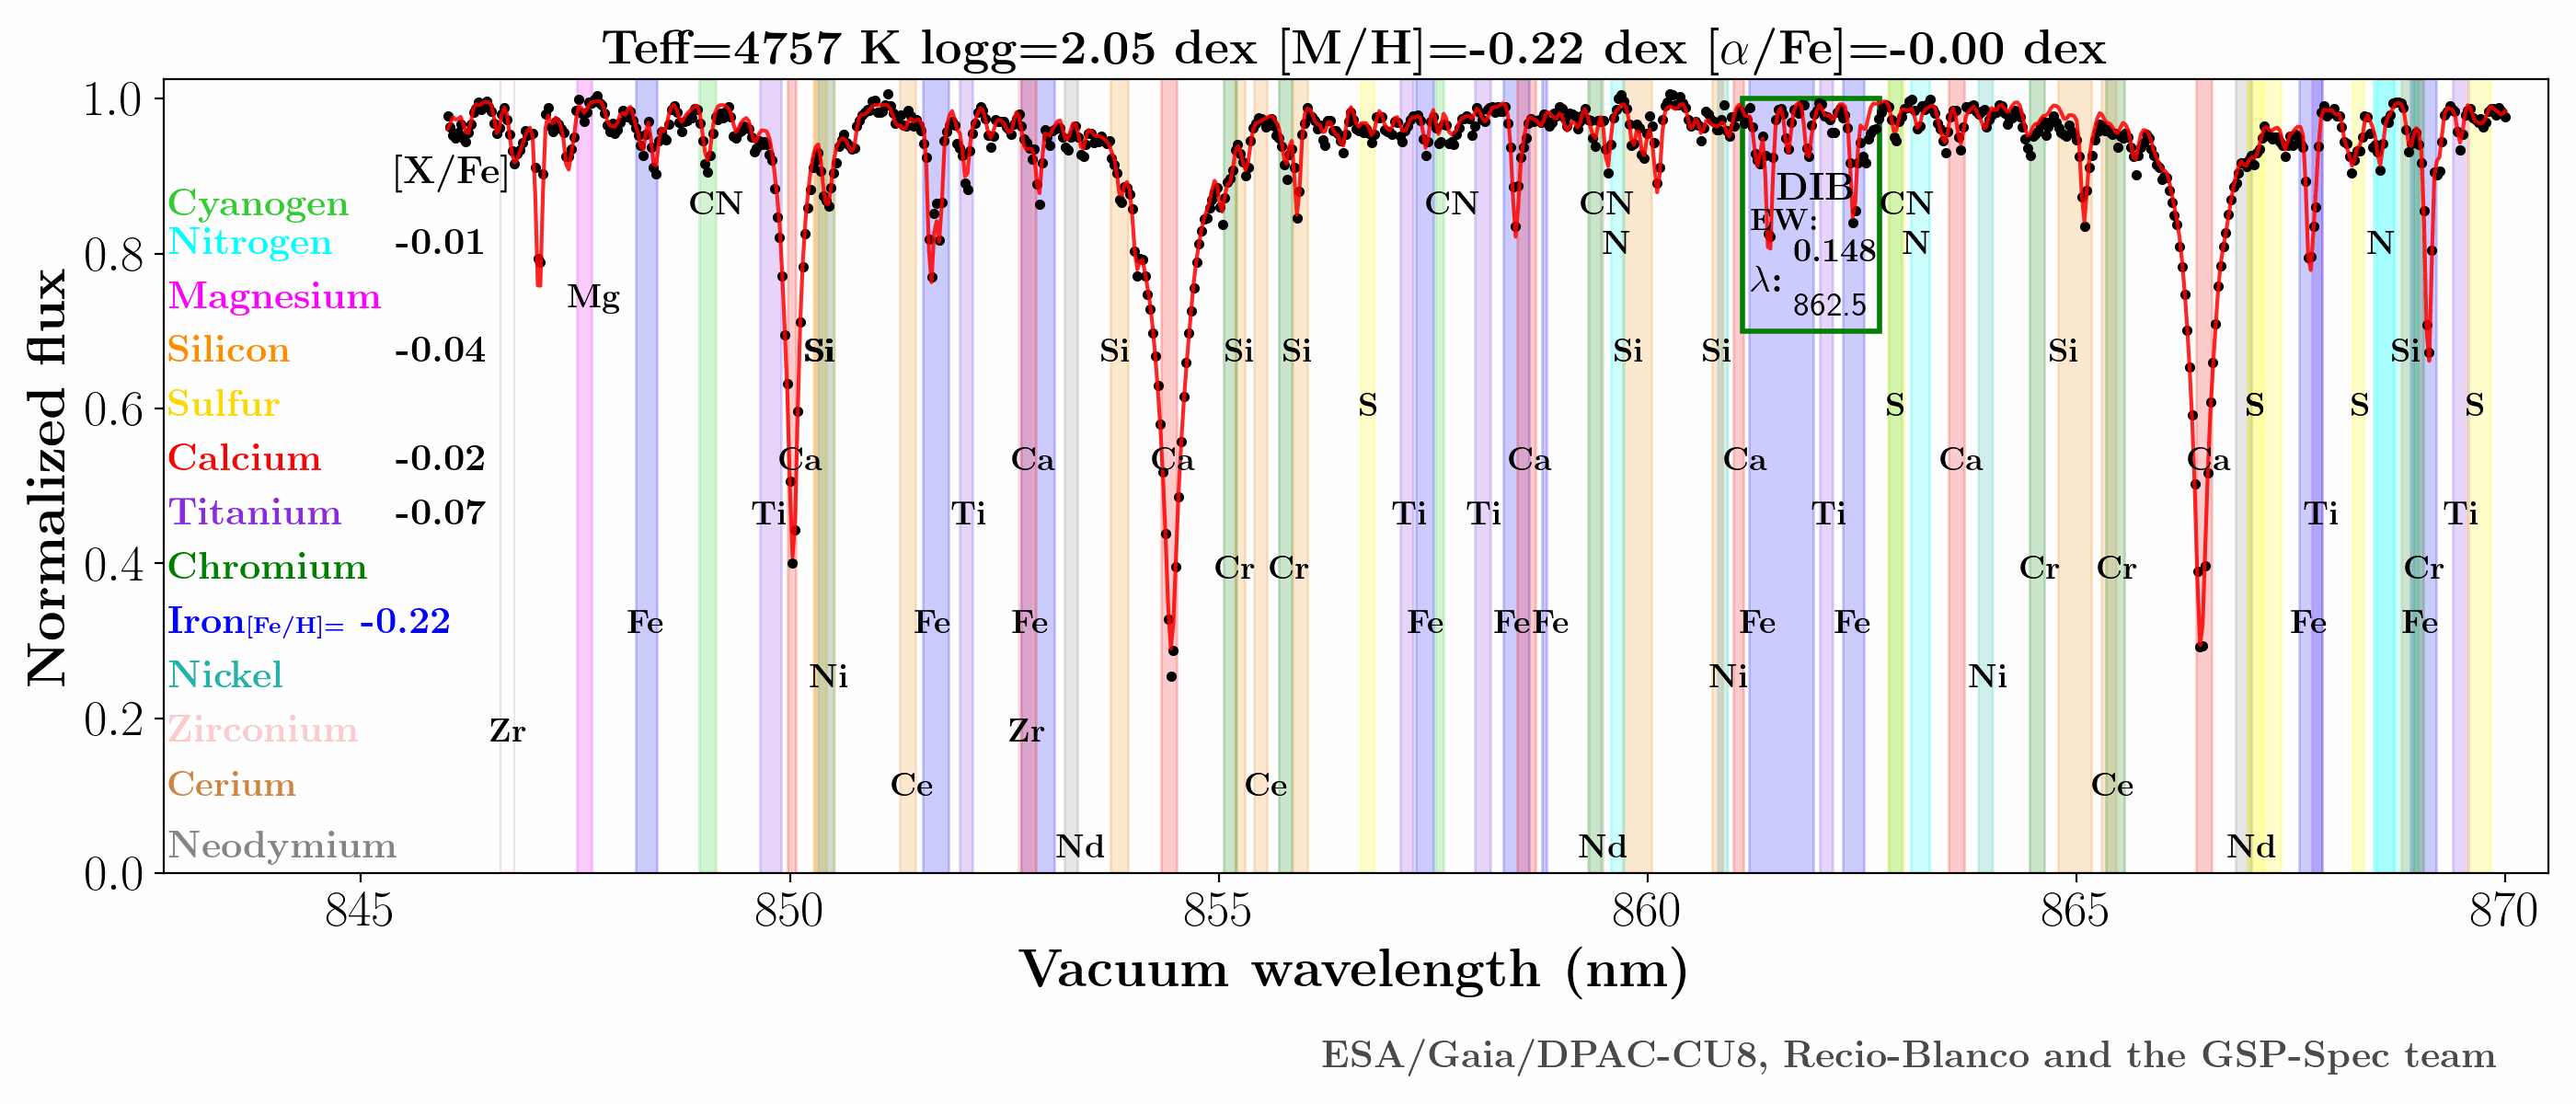

https://www.cosmos.esa.int/web/gaia/iow_20210709#

Different types of stars will have different looking spectras.
However, the spectra we get from Gaia are on a small range of wavelength, and not all interactions/emissions are known, neither necessarily the types of stars! 
On the other hand, GALAH observed those stars at larger wavelengths range (verify) and thus was able to produce some labels about metallicities and so on. 

One question that might be interesting to ask is: is there enough information from the Gaia spectra to predict those labels --we just don't know yet the "physically informed" way of doing it, but maybe it is possible! 

We're also interested in finding out if we see patterns or clusters in our dataset: they might indicate different type of stars (or, spoiler alert, observational issues...). 
Anomalies are also of interest, either finding extremely rare objects that we need to explain, or data impacted by observational artifact (most likely). 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error 


In [1]:
import cudf

/home/ludast/miniconda3/envs/rapids-25.02/lib/python3.12/site-packages/cudf/utils/_ptxcompiler.py:64: UserWarning: Error getting driver and runtime versions:

stdout:



stderr:

Traceback (most recent call last):
  File "/home/ludast/miniconda3/envs/rapids-25.02/lib/python3.12/site-packages/numba_cuda/numba/cuda/cudadrv/driver.py", line 296, in ensure_initialized
    self.cuInit(0)
  File "/home/ludast/miniconda3/envs/rapids-25.02/lib/python3.12/site-packages/numba_cuda/numba/cuda/cudadrv/driver.py", line 346, in safe_cuda_api_call
    self._check_ctypes_error(fname, retcode)
  File "/home/ludast/miniconda3/envs/rapids-25.02/lib/python3.12/site-packages/numba_cuda/numba/cuda/cudadrv/driver.py", line 414, in _check_ctypes_error
    raise CudaAPIError(retcode, msg)
numba.cuda.cudadrv.driver.CudaAPIError: [100] Call to cuInit results in CUDA_ERROR_NO_DEVICE

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "<string>", line 4, 

### Pre-processing

The spectra are in normalized flux, so they don't need to much pre-processing. However, **some spectra can contain NaN values; replace those values by the median of the given spectrum (i.e. of that row of the matrix) before carrying on!**  (your code will most likely crash if you don't anyway.)

Note the spectra file are .npy format you can load with numpy; the information tables can be loaded with pandas.

In [2]:
# Load the .npy file using numpy
data_dir = './data/'

# Read data matrices
spectra_withgalah_np = np.load(data_dir + 'spec_rvs_wise_galah.npy')
spectra_withgalah = pd.DataFrame(spectra_withgalah_np)

spectraNOgal_np = np.load(data_dir + "spec_NOgalah_rvswise.npy")
spectraNOgal = pd.DataFrame(spectraNOgal_np)

# Read additional information
gaiagal_info = pd.read_csv(data_dir + "gaiaGalah_info_rvswisegalah.csv")
gaiaNOgal_info = pd.read_csv(data_dir + "gaia_info_rvswiseNOgalah.csv")

# Read IDs
ids_rvs_wise_galah_np = np.load(data_dir + 'ids_rvs_wise_galah.npy')
ids_rvs_wise_galah = pd.DataFrame(ids_rvs_wise_galah_np)

ids_NOgalah_rvswise_np = np.load(data_dir + 'ids_NOgalah_rvswise.npy')
ids_NOgalah_rvswise = pd.DataFrame(ids_NOgalah_rvswise_np)

/tmp/ipykernel_20083/1692582848.py:12: DtypeWarning: Columns (310) have mixed types. Specify dtype option on import or set low_memory=False.
  gaiagal_info = pd.read_csv(data_dir + "gaiaGalah_info_rvswisegalah.csv")


In [3]:
print("Number of NaN (Gaia with galah)")
print("  Spectra =", spectra_withgalah.isna().sum().sum())
print("  info =", gaiagal_info.isna().sum().sum())
print("  IDs =", ids_rvs_wise_galah.isna().sum().sum())

Number of NaN (Gaia with galah)
  Spectra = 131180
  info = 992747
  IDs = 0


In [4]:
print("Number of NaN (Gaia NO galah)")
print("  Spectra =", spectraNOgal.isna().sum().sum())
print("  info =", gaiaNOgal_info.isna().sum().sum())
print("  IDs =", ids_NOgalah_rvswise.isna().sum().sum())

Number of NaN (Gaia NO galah)
  Spectra = 147436
  info = 731018
  IDs = 0


In [5]:
# Replace NaN values in each row with the median of that row
spectra_withgalah = spectra_withgalah.T.apply(lambda x: x.fillna(x.median()), axis=0).T
spectraNOgal = spectraNOgal.T.apply(lambda x: x.fillna(x.median()), axis=0).T

In [6]:
print("Number of NaN for each dataset")
print("Spectra with galah =", spectra_withgalah.isna().sum().sum())
print("Spectra NO galah =", spectraNOgal.isna().sum().sum())

Number of NaN for each dataset
Spectra with galah = 0
Spectra NO galah = 0


In [7]:
print("Shape of DF")
print("Spectra with galah", spectra_withgalah.shape)
print("Spectra NO galah", spectraNOgal.shape)

Shape of DF
Spectra with galah (21556, 2401)
Spectra NO galah (22295, 2401)


Try to plot a few spectra to see if you see differences between them!

In [8]:
# Standardize or Normalize each row
def scale_row(row):
    #scaler = StandardScaler() # Each row is now standardized: mean = 0, std = 1
    scaler = MinMaxScaler()    # Normalize each row to [0, 1]
    row_scaled = scaler.fit_transform(row.values.reshape(-1, 1)).flatten()
    return pd.Series(row_scaled, index=row.index)

spectra_withgalah_scaled = spectra_withgalah.apply(scale_row, axis=1)
spectraNOgal_scaled = spectraNOgal.apply(scale_row, axis=1)

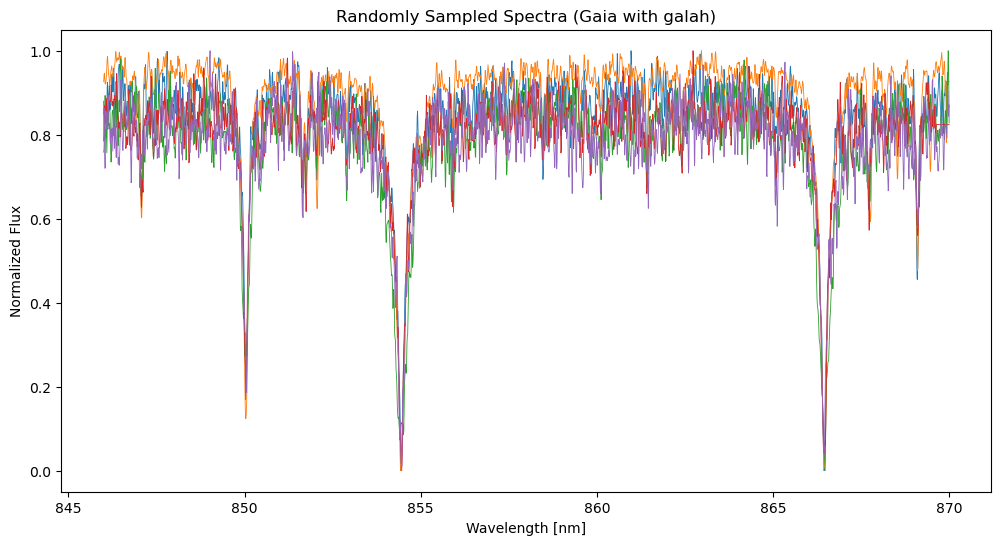

In [9]:
# Calculate the number of steps to include both ends
wl_step = 0.01
wl_min  = 846.0
wl_max  = 870.0
num_points = int((wl_max - wl_min) / wl_step) + 1  # +1 to include the endpoint

# Create the wavelength range
wl_range = np.linspace(wl_min, wl_max, num=num_points)

# Randomly sample 5 spectra (rows)
#sampled_spectra = spectra_withgalah.sample(n=5, random_state=24)
sampled_spectra = spectra_withgalah_scaled.sample(n=5, random_state=20250320)

# Plot each sampled spectrum as scatter points
plt.figure(figsize=(12, 6))
for idx, (label, row) in enumerate(sampled_spectra.iterrows()):
    plt.plot(wl_range, row, label=label, lw=0.6)
    #plt.scatter(wl_range, row, label=label, s=2)  # s controls marker size

plt.xlabel('Wavelength [nm]')
plt.ylabel('Normalized Flux')
plt.title('Randomly Sampled Spectra (Gaia with galah)')
ax = plt.gca()
#plt.legend()
plt.show()


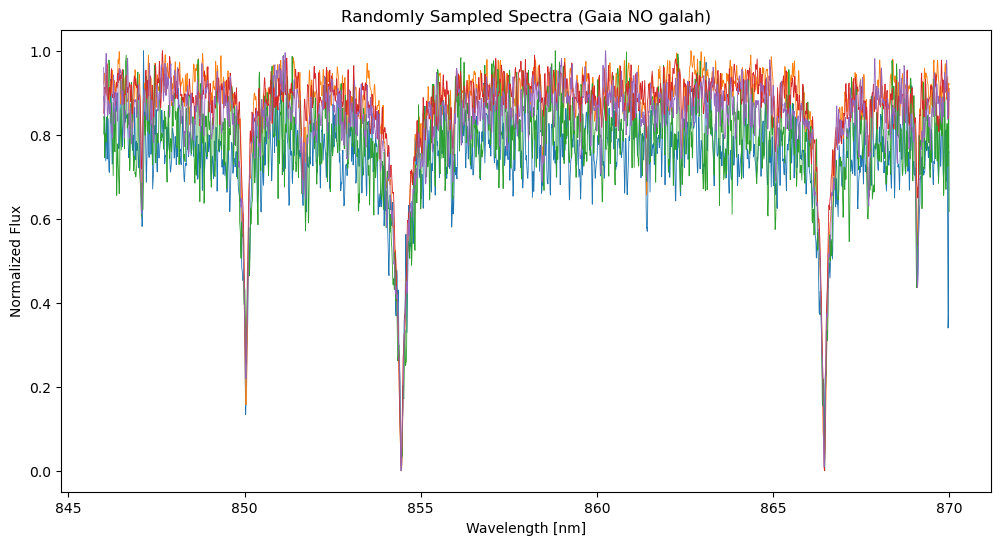

In [10]:
# Calculate the number of steps to include both ends
wl_step = 0.01
wl_min  = 846.0
wl_max  = 870.0
num_points = int((wl_max - wl_min) / wl_step) + 1  # +1 to include the endpoint

# Create the wavelength range
wl_range = np.linspace(wl_min, wl_max, num=num_points)

# Randomly sample 5 spectra (rows)
#sampled_spectra = spectra_withgalah.sample(n=5, random_state=24)
sampled_spectra = spectraNOgal_scaled.sample(n=5, random_state=20250320)

# Plot each sampled spectrum as scatter points
plt.figure(figsize=(12, 6))
for idx, (label, row) in enumerate(sampled_spectra.iterrows()):
    plt.plot(wl_range, row, label=label, lw=0.6)
    #plt.scatter(wl_range, row, label=label, s=2)  # s controls marker size

plt.xlabel('Wavelength [nm]')
plt.ylabel('Normalized Flux')
plt.title('Randomly Sampled Spectra (Gaia NO galah)')
ax = plt.gca()
#plt.legend()
plt.show()


Set up the regression task
- Filter for valid fe_h labels
- Split the data into training and testing sets
- Train and tune
  * RandomForestRegressor
  * LinearRegression
  * KNeighborsRegressor
- Plot the true vs. predicted values
- Summarize the MSE results in a table

### Metallicity Regression

One measurement that is interesting to astronomers is "metallicity". This can mean different thing, but in the context of this project, we will be considering the column "fe_h" in gaiagal_info. We will use this as our label for the regression task.\
For now, we can only use the spectra_withgalah / gaiagal_info since they are the only ones with this information. Since we need supervision for this task, ensure that you have proper labels for all your spectra --some might have a NaN fe_h!


Build a pipeline for this regression problem: construct a training and test set from the data, and train models to predict.Try (e.g. using sklearn) RandomForestRegressor (explore different hyper-parameters), LinearRegressor, and KNeighborsRegressor.\
You can plot the true labels (x-axis) vs the predicted labels (y-axis), for the train and test data.\
Summarize the error in prediction (using the Mean Square Error) for the models in a table.


In [11]:
metallicity_label = "fe_h"

# Number of NaN
invalid_rows_num = gaiagal_info[metallicity_label].isna().sum()
print("NaN values in", metallicity_label, "column =", invalid_rows_num)

# Find rows where Y is NOT NaN
valid_rows = gaiagal_info[metallicity_label].notna()
labels = gaiagal_info[metallicity_label]

# Filter both X and Y based on valid rows
X = spectra_withgalah_scaled[valid_rows].reset_index(drop=True)
y = labels.loc[valid_rows].reset_index(drop=True)

NaN values in fe_h column = 625


In [12]:
y.describe()

count    20931.000000
mean        -0.215673
std          0.348419
min         -4.781486
25%         -0.371472
50%         -0.168949
75%         -0.003002
max          1.000000
Name: fe_h, dtype: float64

In [13]:
# Split the data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20250320)

In [14]:
%%time
# creating a linear regression model 
model = LinearRegression() 

# fitting the model 
model.fit(X_train,y_train)

# Predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# model evaluation 
print("Multiple linear regression")
print('  mean_squared_error : ', mean_squared_error(y_test, y_test_pred)) 
print('  mean_absolute_error : ', mean_absolute_error(y_test, y_test_pred)) 
print("  R^2 Score:", r2_score(y_test, y_test_pred))

Multiple linear regression
  mean_squared_error :  0.05055684777984632
  mean_absolute_error :  0.1546444818416791
  R^2 Score: 0.5627574494125013
CPU times: user 13.2 s, sys: 1.21 s, total: 14.5 s
Wall time: 2.07 s


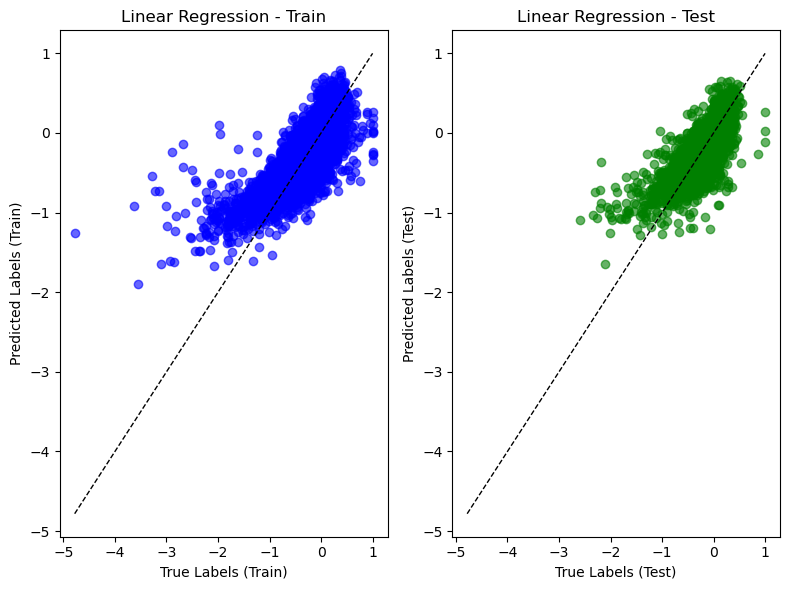

In [15]:
# Plot true vs predicted for both
plt.figure(figsize=(8, 6))

# Reference line (perfect prediction line)
min_val = min(y.min(), y_train_pred.min(), y_test_pred.min())
max_val = max(y.max(), y_train_pred.max(), y_test_pred.max())

# --- Train plot ---
plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred, color='blue', alpha=0.6)
plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=1)
plt.xlabel("True Labels (Train)")
plt.ylabel("Predicted Labels (Train)")
plt.title("Linear Regression - Train")

# --- Test plot ---
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred, color='green', alpha=0.6)
plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=1)
plt.xlabel("True Labels (Test)")
plt.ylabel("Predicted Labels (Test)")
plt.title("Linear Regression - Test")

plt.tight_layout()
plt.show()


In [16]:
%%time
# Train the Random Forest model
model = RandomForestRegressor(n_estimators=16, max_depth=8, n_jobs=8, random_state=20250320)
#model = RandomForestRegressor(n_estimators=16, max_depth=8, random_state=20250320) # Don't set n_jobs if running on GPU
model.fit(X_train, y_train)

# Predict for train and test sets
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# model evaluation 
print("Random Forest regression")
print('  mean_squared_error : ', mean_squared_error(y_test, y_test_pred)) 
print('  mean_absolute_error : ', mean_absolute_error(y_test, y_test_pred)) 
print("  R^2 Score:", r2_score(y_test, y_test_pred))

Random Forest regression
  mean_squared_error :  0.06003631157953631
  mean_absolute_error :  0.17665432869658082
  R^2 Score: 0.4807739968834339
CPU times: user 16min 33s, sys: 320 ms, total: 16min 34s
Wall time: 2min 30s


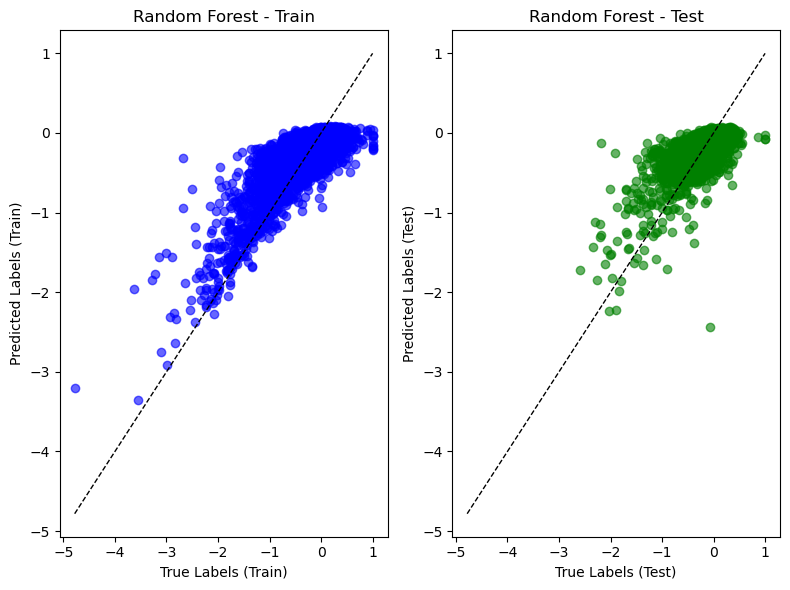

In [17]:
# Plot true vs predicted for both
plt.figure(figsize=(8, 6))

# Reference line (perfect prediction line)
min_val = min(y.min(), y_train_pred.min(), y_test_pred.min())
max_val = max(y.max(), y_train_pred.max(), y_test_pred.max())

# --- Train plot ---
plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred, color='blue', alpha=0.6)
plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=1)
plt.xlabel("True Labels (Train)")
plt.ylabel("Predicted Labels (Train)")
plt.title("Random Forest - Train")

# --- Test plot ---
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred, color='green', alpha=0.6)
plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=1)
plt.xlabel("True Labels (Test)")
plt.ylabel("Predicted Labels (Test)")
plt.title("Random Forest - Test")

plt.tight_layout()
plt.show()


In [18]:
%%time
# Train the K-Nearest Neighbors Regressor
knn = KNeighborsRegressor(n_neighbors=5, n_jobs=8)
knn.fit(X_train, y_train)

# Predict on train and test sets
y_train_pred = knn.predict(X_train)
y_test_pred = knn.predict(X_test)

# Predict for train and test sets
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# model evaluation 
print("KNN regression")
print('  mean_squared_error : ', mean_squared_error(y_test, y_test_pred)) 
print('  mean_absolute_error : ', mean_absolute_error(y_test, y_test_pred)) 
print("  R^2 Score:", r2_score(y_test, y_test_pred))

KeyboardInterrupt: 

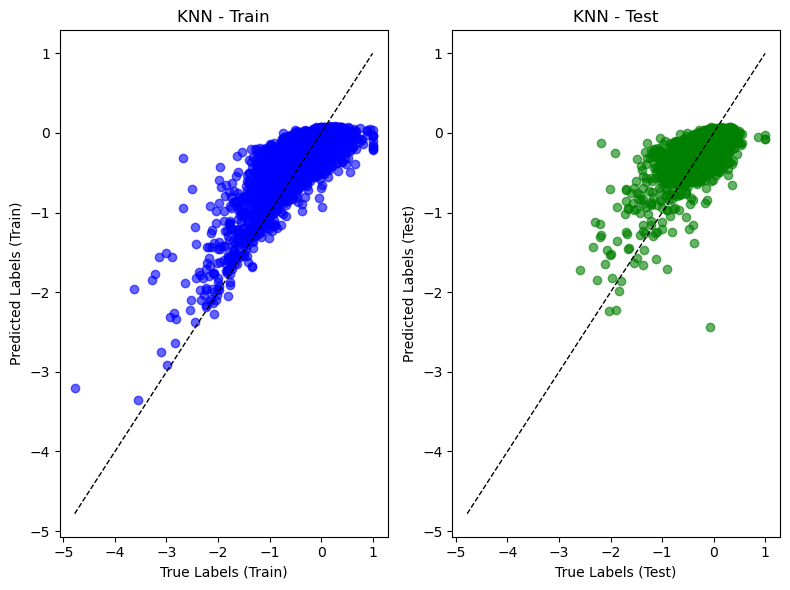

In [19]:
# Plot true vs predicted for both
plt.figure(figsize=(8, 6))

# Reference line (perfect prediction line)
min_val = min(y.min(), y_train_pred.min(), y_test_pred.min())
max_val = max(y.max(), y_train_pred.max(), y_test_pred.max())

# --- Train plot ---
plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred, color='blue', alpha=0.6)
plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=1)
plt.xlabel("True Labels (Train)")
plt.ylabel("Predicted Labels (Train)")
plt.title("KNN - Train")

# --- Test plot ---
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred, color='green', alpha=0.6)
plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=1)
plt.xlabel("True Labels (Test)")
plt.ylabel("Predicted Labels (Test)")
plt.title("KNN - Test")

plt.tight_layout()
plt.show()


## Visualization and dimensionality reduction exploration

Apply PCA on the spectra_withgalah, and \
  a) plot the explained variance ratio as a function of the number of components; \
  b) plot scatter plots of the lower-dimensional PCA-transformed space using few components (e.g. using the 0th/1st components, 0th/2d); what do you observe? \
  c) plot the first 3 PCA components (i.e. in "spectra" space) 
  
 

Apply PCA on the other spectra dataset (spec_NOgalah_rvswise) and compare the results (specifically b) and c)). 


(Optional): Try another algorithm for visualization/dimensionality reduction like t-SNE or UMAP.

## Clustering

Using the lower dimensional space from PCA (e.g. with even only 2 or 3 components) on the spectraNOgal dataset, run a clustering algorithm to separate your data. \
For each of the cluster you find, plot the average spectra of this cluster. 

## Anomaly Detection 


Run IsolationForest on the spectraNOGal (in high-dimension, not reduced). Find the 5 most anomalous spectra using the score_samples function, and report them back on the PCA projection plot. Plot as well the 5 spectra. What do you observe? 

